In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import time


In [9]:
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden_size=64):
        super(ActorCritic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc_actor = nn.Linear(hidden_size, action_size)
        self.fc_critic = nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        logits = self.fc_actor(x)
        value = self.fc_critic(x)
        return logits, value


In [10]:
class PPOAgent:
    def __init__(self, state_size, action_size, seed=170715, lr=3e-4, gamma=0.99,
                 K_epochs=4, eps_clip=0.2, entropy_coef=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.K_epochs = K_epochs
        self.eps_clip = eps_clip
        self.entropy_coef = entropy_coef

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy = ActorCritic(state_size, action_size, seed).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)

        self.policy_old = ActorCritic(state_size, action_size, seed).to(self.device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

        self.memory = []

    def select_action(self, state):
        state = torch.FloatTensor(state).to(self.device)
        logits, value = self.policy_old(state)
        probs = F.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        self.memory.append({
            'state': state,
            'action': action,
            'log_prob': dist.log_prob(action),
            'reward': 0,
            'done': False,
            'value': value
        })

        return action.item()

    def update_rewards(self, reward, done):
        if self.memory:
            self.memory[-1]['reward'] = reward
            self.memory[-1]['done'] = done

    def compute_returns_and_advantages(self, next_value=0):
        rewards = []
        dones = []
        for transition in reversed(self.memory):
            rewards.insert(0, transition['reward'])
            dones.insert(0, transition['done'])

        returns = []
        G = next_value
        for reward, done in zip(reversed(rewards), reversed(dones)):
            if done:
                G = 0
            G = reward + self.gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns).float().to(self.device)

        returns = (returns - returns.mean()) / (returns.std() + 1e-5)

        values = torch.cat([t['value'] for t in self.memory]).squeeze()
        advantages = returns - values.detach()

        return returns, advantages

    def update(self):
        states = torch.stack([t['state'] for t in self.memory]).to(self.device)
        actions = torch.tensor([t['action'] for t in self.memory]).to(self.device)
        old_log_probs = torch.stack([t['log_prob'] for t in self.memory]).to(self.device)
        returns, advantages = self.compute_returns_and_advantages()

        for _ in range(self.K_epochs):
            logits, values = self.policy(states)
            probs = F.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)

            log_probs = dist.log_prob(actions)
            entropy = dist.entropy()

            ratios = torch.exp(log_probs - old_log_probs.detach())

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            loss_actor = -torch.min(surr1, surr2).mean()

            loss_critic = self.MseLoss(values.squeeze(), returns)

            loss = loss_actor + 0.5 * loss_critic - self.entropy_coef * entropy.mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())

        self.memory = []


In [11]:
def train_ppo(env, agent, num_episodes=1000, max_steps=200, save_path='best_ppo_model.pth',
              update_timestep=2000, log_interval=10):
    reward_history = []
    best_avg_reward = -np.inf
    avg_reward_deque = deque(maxlen=100)

    timestep = 0
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0
        for t in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update_rewards(reward, done)
            total_reward += reward
            timestep += 1
            state = next_state

            if timestep % update_timestep == 0:
                agent.update()

            if done:
                break

        reward_history.append(total_reward)
        avg_reward_deque.append(total_reward)
        avg_reward = np.mean(avg_reward_deque)

        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            torch.save(agent.policy.state_dict(), save_path)
            print(f"Episode {episode}: New best average reward {best_avg_reward:.2f}. Model saved!")

        if episode % log_interval == 0:
            print(f"Episode {episode}\tAverage Reward: {avg_reward:.2f}")

    print("Training completed.")
    return reward_history


In [12]:
def evaluate_ppo(env, agent, n_episodes=20, max_steps=200, render=False):
    agent.policy.eval()
    rewards = []

    with torch.no_grad():
        for episode in range(1, n_episodes + 1):
            state = env.reset()
            total_reward = 0
            for t in range(max_steps):
                if render:
                    env.render()
                state_tensor = torch.FloatTensor(state).to(agent.device)
                logits, _ = agent.policy_old(state_tensor)
                probs = F.softmax(logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample().item()
                next_state, reward, done, _ = env.step(action)
                total_reward += reward
                state = next_state
                if done:
                    break
            rewards.append(total_reward)
            print(f"Evaluation Episode {episode}: Total Reward = {total_reward}")

    avg_reward = np.mean(rewards)
    print(f"\nAverage Reward over {n_episodes} Evaluation Episodes: {avg_reward}")
    agent.policy.train()
    return avg_reward, rewards


In [13]:
env = gym.make("CartPole-v1")
env.seed(42)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = PPOAgent(state_size, action_size, seed=42, lr=3e-4, gamma=0.99,
                K_epochs=4, eps_clip=0.2, entropy_coef=0.01)

num_episodes = 1000
max_steps = 200
save_path = "best_ppo_model.pth"
update_timestep = 2000
log_interval = 10

start_time = time.time()
reward_history = train_ppo(env, agent, num_episodes, max_steps, save_path,
                            update_timestep, log_interval)
end_time = time.time()
print(f"Training Time: {(end_time - start_time)/60:.2f} minutes")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode 1: New best average reward 10.00. Model saved!
Episode 2: New best average reward 19.00. Model saved!
Episode 6: New best average reward 21.33. Model saved!
Episode 8: New best average reward 24.12. Model saved!
Episode 10: New best average reward 24.30. Model saved!
Episode 10	Average Reward: 24.30
Episode 12: New best average reward 24.67. Model saved!
Episode 16: New best average reward 24.88. Model saved!
Episode 17: New best average reward 25.18. Model saved!
Episode 19: New best average reward 25.21. Model saved!
Episode 20	Average Reward: 24.60
Episode 30	Average Reward: 23.10
Episode 40	Average Reward: 23.68
Episode 50	Average Reward: 23.26
Episode 60	Average Reward: 23.47
Episode 70	Average Reward: 22.87
Episode 80	Average Reward: 23.32
Episode 90	Average Reward: 23.28
Episode 100	Average Reward: 23.30
Episode 110	Average Reward: 23.02
Episode 120	Average Reward: 22.74
Episode 130	Average Reward: 23.98
Episode 140	Average Reward: 23.67
Episode 150	Average Reward: 23.36

Evaluation Episode 1: Total Reward = 14.0
Evaluation Episode 2: Total Reward = 20.0
Evaluation Episode 3: Total Reward = 25.0
Evaluation Episode 4: Total Reward = 21.0
Evaluation Episode 5: Total Reward = 19.0
Evaluation Episode 6: Total Reward = 22.0
Evaluation Episode 7: Total Reward = 17.0
Evaluation Episode 8: Total Reward = 16.0
Evaluation Episode 9: Total Reward = 19.0
Evaluation Episode 10: Total Reward = 16.0
Evaluation Episode 11: Total Reward = 12.0
Evaluation Episode 12: Total Reward = 25.0
Evaluation Episode 13: Total Reward = 36.0


<ipython-input-14-b46b8a7a952c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.policy.load_state_dict(torch.load(save_path))


Evaluation Episode 14: Total Reward = 21.0
Evaluation Episode 15: Total Reward = 24.0
Evaluation Episode 16: Total Reward = 27.0
Evaluation Episode 17: Total Reward = 36.0
Evaluation Episode 18: Total Reward = 20.0
Evaluation Episode 19: Total Reward = 12.0
Evaluation Episode 20: Total Reward = 18.0

Average Reward over 20 Evaluation Episodes: 21.0


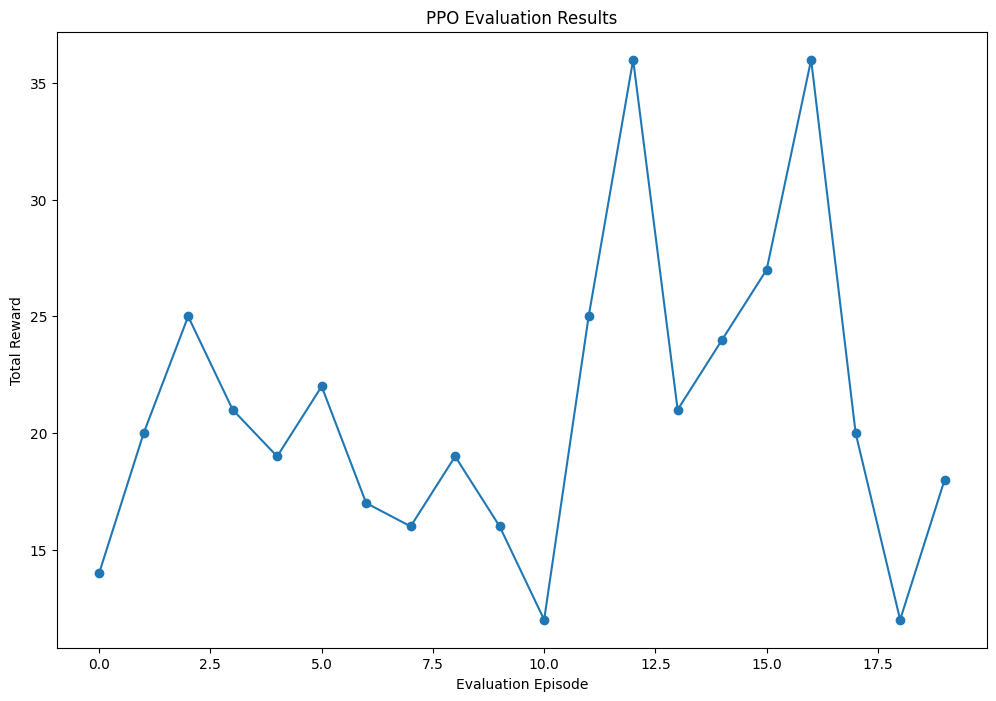

In [14]:
agent.policy.load_state_dict(torch.load(save_path))
agent.policy_old.load_state_dict(agent.policy.state_dict())

avg_reward, rewards = evaluate_ppo(env, agent, n_episodes=20, max_steps=200, render=False)

plt.figure(figsize=(12,8))
plt.plot(rewards, marker='o')
plt.xlabel('Evaluation Episode')
plt.ylabel('Total Reward')
plt.title('PPO Evaluation Results')
plt.show()

env.close()
